In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

/home/vjacquot/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/vjacquot/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Load the Data
Note that `ratings` is a sparse matrix that in the shape of (num_items, num_users)

In [2]:
from helpers import load_data, preprocess_data

path_dataset = "data/data_train.csv"
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


### Plot the number of ratings per movie and user

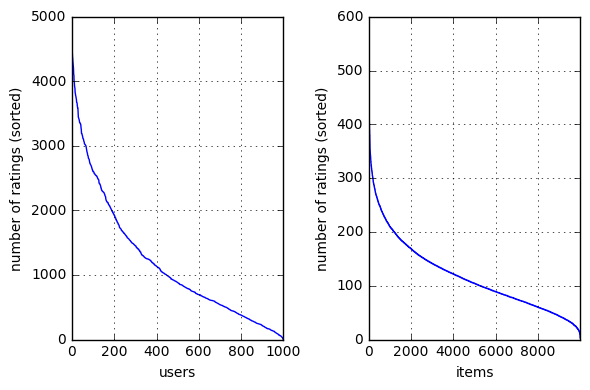

min # of items per user = 8, min # of users per item = 3.


In [4]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

### Split the data into a train and test set

In [29]:
from helpers import split_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=1, p_test=0.1)

Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065327
Total number of nonzero elements in test data:111625


In [55]:
# temporary, just to create data subsets for tests
ratings_c = ratings.copy()
train_c = train.copy()
test_c = test.copy()
print(train.shape)
print(test.shape)
train_ = train[:100,:100]
test_ = test[:100,:100]

(10000, 1000)
(10000, 1000)


### Learn the Matrix Factorization using SGD

#### Initialize matrix factorization

In [59]:
def init_MF(train, num_features):
    """init the parameter for matrix factorization."""
    num_user = train.shape[1]
    num_item = train.shape[0]
    std = 0.1
    user_features = std * np.random.randn(num_features,num_user) #user_features.shape (20,1000)
    item_features = std * np.random.randn(num_item, num_features) #item_features.shape (10000,20)
    return user_features, item_features

#### Compute the cost by the method of matrix factorization

In [8]:
def compute_error(data, user_features, item_features, nz):
    """compute the loss (MSE) of the prediction of nonzero elements."""
    sum_err = 0
    for d, n in nz:
        err = data[d,n] - np.dot(item_features[d,:],user_features[:,n])
        sum_err += err**2
    rmse = 0.5*sum_err/len(nz)
    return rmse

In [60]:
from helpers import calculate_mse

def matrix_factorization_SGD(train, test, K_feat, epochs):
    """matrix factorization by SGD."""
    # define parameters
    gamma = 0.01
    num_features = K_feat   # K in the lecture notes
    lambda_user = 0.1
    lambda_item = 0.7
    num_epochs = epochs     # number of full passes through the train set
    errors = [0]
    
    # set seed
    np.random.seed(988)

    # init matrix
    user_features, item_features = init_MF(train, num_features)
    #user_features = saved_user_features.copy()
    #item_features = saved_item_features.copy()
    
    # find the non-zero ratings indices 
    nz_row, nz_col = train.nonzero()
    nz_train = list(zip(nz_row, nz_col))

    print("learn the matrix factorization using SGD...")
    for it in range(num_epochs):        
        # shuffle the training rating indices
        np.random.shuffle(nz_train)
        
        # decrease step size
        gamma /= 1.2
        
        for d, n in nz_train: # iterate over non zero elements
            e_dn = train[d,n] - np.dot(item_features[d,:],user_features[:,n])
            for k in range(num_features): # subtract the gradient for each feature
                user_features[k,n] = user_features[k,n] + gamma * e_dn * item_features[d,k] #- lambda_user * user_features[k,n]  
                item_features[d,k] = item_features[d,k] + gamma * e_dn * user_features[k,n] #- lambda_ * item_features[d,k]
        
        rmse_train = compute_error(train, user_features, item_features, nz_train) # for each epoch, last rmse_train value is returned
        errors.append(rmse_train)

    print("iter: {}, RMSE on training set: {}.".format(it, rmse_train))
    # evaluate the test error
    nz_row, nz_col = test.nonzero()
    nz_test = list(zip(nz_row, nz_col))
    rmse_test = compute_error(test, user_features, item_features, nz_train) 
    print("RMSE on test data: {}.".format(rmse_test))
    return user_features, item_features, rmse_train, rmse_test

user_features, item_features, rmse_train, rmse_test = matrix_factorization_SGD(train_c, test_c,20,10)

learn the matrix factorization using SGD...
iter: 9, RMSE on training set: 0.45788968731115065.
RMSE on test data: 7.587707006620173.


In [61]:
# save matrices W and Z after 20 iterations
saved_user_features = user_features.copy()
saved_item_features = item_features.copy()

#### Plot error for different values of K without cross-validation

K=20.000, Training RMSE=0.000, Testing RMSE=0.000
K=25.000, Training RMSE=0.100, Testing RMSE=0.500
K=30.000, Training RMSE=0.200, Testing RMSE=1.000
K=35.000, Training RMSE=0.300, Testing RMSE=1.500
K=40.000, Training RMSE=0.400, Testing RMSE=2.000
K=45.000, Training RMSE=0.500, Testing RMSE=2.500
K=50.000, Training RMSE=0.600, Testing RMSE=3.000


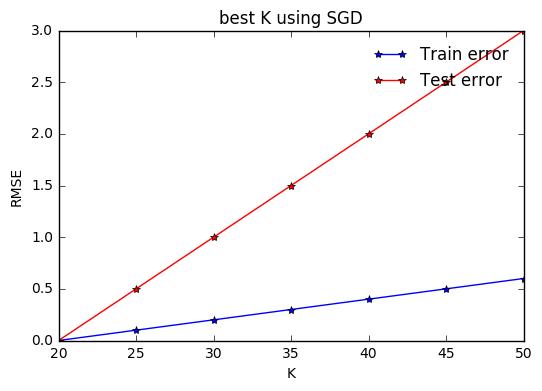

In [4]:
from plots import plot_train_test

def find_best_K(train,test):
    Ks_feat = np.array([20, 25, 30, 35, 40, 45, 50])
    n_epochs = 4 # only 4 to try
    
    rmse_tr = []
    rmse_te = []
    for ind, K_feat in enumerate(Ks_feat):
        user_features, item_features, loss_tr, loss_te = matrix_factorization_SGD(train, test, K_feat, n_epochs)
        # average user_features and item_features
        rmse_tr.append(loss_tr)
        rmse_te.append(loss_te)

        print("K={K_:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               K_=K_feat, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, Ks_feat)
    
find_best_K(train_c,test_c)

#### Plot error for different values of K with cross-validation

learn the matrix factorization using SGD...
iter: 3, RMSE on training set: 7.05213188552924.
RMSE on test data: 0.0029990456373580137.
learn the matrix factorization using SGD...
iter: 3, RMSE on training set: 7.06909159872774.
RMSE on test data: 0.0030580150048424566.
learn the matrix factorization using SGD...
iter: 3, RMSE on training set: 7.007225226714013.
RMSE on test data: 0.003099004546585238.
learn the matrix factorization using SGD...
iter: 3, RMSE on training set: 7.041997222454271.
RMSE on test data: 0.0033636610448064415.
learn the matrix factorization using SGD...
iter: 3, RMSE on training set: 7.004244534574218.
RMSE on test data: 0.004118912557716272.
learn the matrix factorization using SGD...
iter: 3, RMSE on training set: 7.019167152900161.
RMSE on test data: 0.004339699628938127.
learn the matrix factorization using SGD...
iter: 3, RMSE on training set: 6.971818216967783.
RMSE on test data: 0.003996639842679376.
learn the matrix factorization using SGD...
iter: 3, R

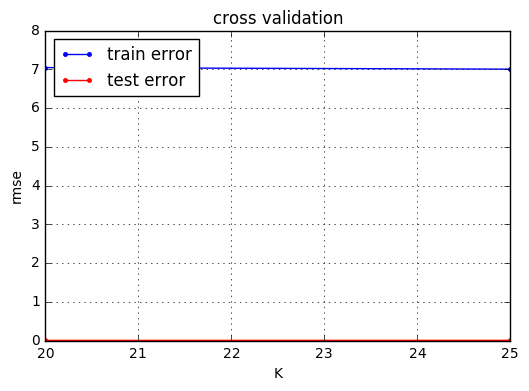

In [63]:
from helpers import build_k_indices, split_data_cross_validation
from plots import cross_validation_visualization

def cross_validation():
    seed = 1
    k_fold = 4
    #Ks_feat = np.array([20, 25, 30, 35, 40, 45, 50])
    Ks_feat = np.array([20, 25])
    epochs = 4
    # define lists to store the loss of training data and test data
    rmse_tr = []
    rmse_te = []
    for K_feat in Ks_feat:
        rmse_tr_tmp = []
        rmse_te_tmp = []
        for k in range(k_fold):
            tr_, te_ = split_data_cross_validation(train_, k_fold, seed, k)
            user_features, item_features, loss_tr, loss_te = matrix_factorization_SGD(tr_, te_, K_feat, epochs)
            rmse_tr_tmp.append(loss_tr)
            rmse_te_tmp.append(loss_te)
        rmse_tr.append(np.mean(rmse_tr_tmp))
        rmse_te.append(np.mean(rmse_te_tmp))
    
    cross_validation_visualization(Ks_feat, rmse_tr, rmse_te)
    
cross_validation()

#### Create prediction matrix

In [62]:
# assign predicted values to prediction matrix
def create_prediction_matrix(prediction):
    nz_row, nz_col = prediction.nonzero()
    nz_pred = list(zip(nz_row, nz_col))
    for d, n in nz_pred:
        pred = np.dot(saved_item_features[d,:],saved_user_features[:,n]) # matrices item_features and user_features are already computed above
        prediction[d,n] = round(pred)
    return prediction

pred = create_prediction_matrix(ratings_c.copy())
print(calculate_mse(ratings_c, pred)) # only when test data and not submission

0.1189789


### Make submission

In [39]:
# load test data
from helpers import load_data, preprocess_data

path_dataset = "data/sampleSubmission.csv"
prediction = load_data(path_dataset)

number of items: 10000, number of users: 1000


In [43]:
from helpers import create_csv_submission_proj2
# estimate prediction matrix using method of ...
#ratings_c = ratings.copy()
prediction = create_prediction_matrix(prediction)
    
# create submission
create_csv_submission_proj2(prediction, 'data/prediction_SGD_2.csv')